# fig_egPopClassifier

### This notebook walks through classification analysis where we are using brain state at stimulus onset to predict delay condition. 





In [1]:
### import packages
import numpy as np
import pandas as pd
import mne
import json as json
from scipy.io import loadmat # to load matlab
from scipy import stats,ndimage,signal,optimize
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa as tsa
import pingouin as pg
import random as rd
import pickle
import os
import subprocess
import pycircstat as circ
import fooof as ff
import tensorpac as tp
from sklearn.metrics import r2_score,pairwise_distances,roc_auc_score,balanced_accuracy_score
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import cross_val_score

# ccdt_func
import ccdt_func as cc



# plot in separate windows, interactive
import matplotlib
#matplotlib.use('macosx')
matplotlib.use('Qt5Agg')

# this makes tight axes 
matplotlib.rcParams['axes.autolimit_mode'] = 'round_numbers'
matplotlib.rcParams['axes.xmargin'] = 0
matplotlib.rcParams['axes.ymargin'] = 0
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt 



import time
#tic = time.perf_counter()
#toc = time.perf_counter()
#print(toc-tic)


# Interesting Subjects:

#  High classifier performance:
# HUP 143, 179, 165

# Low classifier performance:
# HUP 168,152,145, 



/Users/ashwinramayya/anaconda3/envs/environment_name/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/Users/ashwinramayya/anaconda3/envs/environment_name/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.9, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
# SUB FUNCTIONS 

### FIRST, GET SUBJECT Neural data
def getNeuData(subj='HUP179'):
    sc = cc.SubjCollection(subj=subj,filter_bool = None,filter_bool_lbl = 'None')

    # not we do not include badTrials in the query so we have the same number of trials for each electrode
    sc.getPopulationResponse(pow_frange_lbl='HFA',pow_method='wave',
        pow_evQuery='error==0&fastResponse==0',
        do_zscore=True,
        apply_gauss_smoothing=True,
        gauss_sd_scaling=0.075,num_iters=1,
        apply_time_bins=False,
        time_bin_size_ms=100,
        overwriteFlag=False,feat_list_beh = ['zrrt'],run_light=True)

    # get brain state representation during stimulus onset.popMat is trials x time x electrodes. Assume that popMat begins with stimulus onset (can set this with targOn_samp if needed).
    targOn_samp = 0
    S0 = sc.popResponse_dict['popMat'][:,targOn_samp,:]

    
    # [] implement PCA w/ feature selection here 

    
    # return feature matrix (n_trials x n_electrodes)

    return S0,sc

# Subfunction
def getBehData(sc,apply_circ_shift=False):
    beh_feat_dict = {}

    # list of behavioral data to analyze
    beh_var_list = ['rt_ms','zrrt','l_idx']
    # additional:
    #,'zrrt_resid_fast','zrrt_resid_slow','zrrt_pred','errorMemFast','shortDelayMem'

    # collect behavioral data from taskstats
    if apply_circ_shift == True:
        # randomly generate an amount to circularly shift data (constant shift across all behavioral variables)
        shift_idx = np.random.randint(low=0, high=len(sc.popResponse_dict['pow_ev_filt']['RT'].to_numpy()))

    for f in beh_var_list:
        # get beh features (we will ignore s_idx and l_idx for our regression analysis, but use them to estimate null distributions for delay-related differences)
        if f == 'zrrt':
            x = stats.zscore(-1/sc.popResponse_dict['pow_ev_filt']['RT'].to_numpy())
        elif f == 'rt_ms':
            x = sc.popResponse_dict['pow_ev_filt']['RT'].to_numpy()
        elif f == 'l_idx':
            x = sc.popResponse_dict['pow_ev_filt'].eval('delay==1500').to_numpy()
        else:
            x = np.copy(sc.memReg_dict[f])

            # z-score (to help interpret parameters)
            x = (x - np.nanmean(x))/np.nanstd(x)

        # apply circular shift (using common shift_idx computed above)
        if apply_circ_shift == True:

                # circ shift
                x = np.roll(x,shift_idx)

        # update beh_feat_dict
        beh_feat_dict[f] = x 
        
    #  get l_idx_pop
    # get long delay idx (will be shuffled if apply_circ_shift is True\
    #  Also, convert to popResponse_order so we can directly use in classification analysis
    l_idx_pop = sc.pop_ev2pop(beh_feat_dict['l_idx']).astype('bool')
        
    return l_idx_pop


#### calculate BIAS V. VARIANCE FUNCTION for a given set of parameters
def calc_bias_v_variance(X,y,scoring_option = 'roc_auc',n_folds = 10,penalty='l2'):
    # X is the feature matrix (n_trials x n_electrodes (or components) ~ (n_obs x n_features)
    # y is the binary class labels that we are trying to predict. can provide shuffled data for a null distribution
    # scoring_option can be 'roc_auc','balanced_accuracy', or 'accuracy'
    # penalty can be 'l2',l1',or 'none' (for no regularization)
    
    # select solver based on penalty
    if penalty == 'l1':
        solver = 'liblinear'
    else:
        solver = 'lbfgs'
    
    
    # list of hyperparameters
    c_list = [1e-7,1e-6,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000,1e4,1e5,1e6,1e7]
    n_iters = len(c_list)    
    
    # initialize containers
    perf_test = np.zeros(n_iters)
    perf_train = np.zeros(n_iters)

    # loop through models of varying complexity
    for c in range(0,n_iters):
        print(c)
        # initialize model
        clf = LogisticRegression(random_state=0,C=c_list[c],penalty=penalty,solver=solver)

        ##### measure Test performance. using  cross-validated score using stratified k fold (default, with k = 10)
        # cross-val performance
        perf_test[c] = np.mean(cross_val_score(estimator = clf,X = X, y = y, cv = n_folds, scoring = scoring_option))


        ##### measure Train performance
        # fit model to train data
        clf.fit(X = X, y = y)

        # calculate score
        if scoring_option=='roc_auc':
            # auc
            perf_train[c] = roc_auc_score(y_true= y,y_score =clf.predict_proba(X = X)[:,1])
        elif scoring_option=='accuracy':
            # accuracy
            perf_train[c] = clf.score(X = X, y = y)
        elif scoring_option=='balanced_accuracy':
            perf_train[c] = balanced_accuracy_score(y_true= y,y_pred =clf.predict(X = X))
            
    return c_list,perf_train,perf_test,scoring_option

def plot_bias_v_variance(c_list,perf_train,perf_test,scoring_option,fit_perf_reg,fit_perf_noReg):
    # plot bias/variance tradeoff - train vs. test auc
    f = plt.figure()
    ax = plt.subplot(111)
    ax.plot(np.array(c_list),perf_train)
    ax.set_xscale('log')
    ax2= ax.twinx()
    ax2.plot(np.array(c_list),perf_test,color='C1')
    ax.set_xlabel('Model Complexity')
    ax.set_ylabel('Train performance (blue)')
    ax2.set_ylabel('Test performance (orange)')
    ax.set_title('max test '+scoring_option+' = '+str(np.round(np.max(perf_test),3)))
    
    print('Classifer performance w hyperparameter tuning= ',str(np.round(fit_perf_reg,3)))
    print('Best fit performance without regularization = ',str(np.round(fit_perf_noReg,3)))
    
def doBestFit(X,y,n_folds = 10,scoring_option = 'roc_auc'):
    # This performs classification where we tune the regularization hyperparameter (10 options)
    clf=LogisticRegressionCV(random_state=0,Cs=10,penalty='l2',scoring=scoring_option,cv=n_folds).fit(X,y)
     
    # return cross validated score
    
    # calculate average scores across folds
    avg_scores = np.mean(clf.scores_[True],axis=0)
    
    #return
    return np.max(avg_scores)
          
def doFit(X,y,n_folds = 10,scoring_option = 'roc_auc'):
    clf=LogisticRegression(random_state=0,penalty='none')

    return np.mean(cross_val_score(estimator = clf,X = X, y = y, cv = n_folds, scoring = scoring_option))
          
          

In [3]:
# GLOBAL CLASSIFIER PARAMETERS
apply_circ_shift = False
scoring_option = 'roc_auc'
n_folds = 10
penalty='l2'

### High Performance Subjects

In [4]:
%%capture
# HUP179
X,sc = getNeuData(subj='HUP179')
y = getBehData(sc,apply_circ_shift=apply_circ_shift)

In [5]:
%%capture
# calc bias v variance
c_list,perf_train,perf_test,scoring_option = calc_bias_v_variance(X=X,y=y,\
                                                                  scoring_option = scoring_option,\
                                                                  n_folds = n_folds,penalty=penalty)
reg_fit = doBestFit(X,y,n_folds = n_folds,scoring_option = scoring_option)
noreg_fit = doFit(X,y,n_folds = n_folds,scoring_option = scoring_option)

Classifer performance w hyperparameter tuning=  0.561
Best fit performance without regularization =  0.547


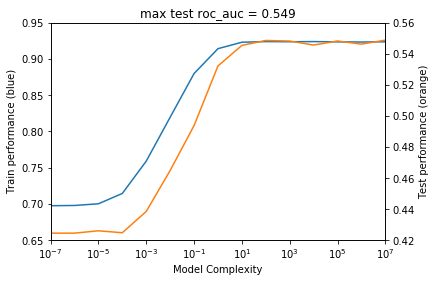

In [6]:
plot_bias_v_variance(c_list,perf_train,perf_test,scoring_option,reg_fit,noreg_fit)

In [7]:
%%capture
# HUP143
X,sc = getNeuData(subj='HUP143')
y = getBehData(sc,apply_circ_shift=apply_circ_shift)

In [8]:
%%capture
# calc bias v variance
c_list,perf_train,perf_test,scoring_option = calc_bias_v_variance(X=X,y=y,\
                                                                  scoring_option = scoring_option,\
                                                                  n_folds = n_folds,penalty=penalty)
reg_fit = doBestFit(X,y,n_folds = n_folds,scoring_option = scoring_option)
noreg_fit = doFit(X,y,n_folds = n_folds,scoring_option = scoring_option)

Classifer performance w hyperparameter tuning=  0.601
Best fit performance without regularization =  0.545


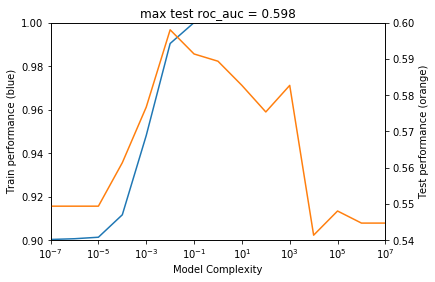

In [9]:
plot_bias_v_variance(c_list,perf_train,perf_test,scoring_option,reg_fit,noreg_fit)

In [10]:
%%capture
# HUP165
X,sc = getNeuData(subj='HUP165')
y = getBehData(sc,apply_circ_shift=apply_circ_shift)

In [11]:
%%capture
# calc bias v variance
c_list,perf_train,perf_test,scoring_option = calc_bias_v_variance(X=X,y=y,\
                                                                  scoring_option = scoring_option,\
                                                                  n_folds = n_folds,penalty=penalty)
reg_fit = doBestFit(X,y,n_folds = n_folds,scoring_option = scoring_option)
noreg_fit = doFit(X,y,n_folds = n_folds,scoring_option = scoring_option)

Classifer performance w hyperparameter tuning=  0.546
Best fit performance without regularization =  0.474


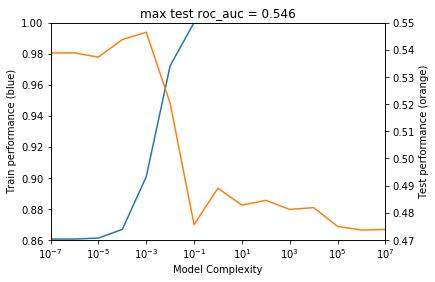

In [12]:
plot_bias_v_variance(c_list,perf_train,perf_test,scoring_option,reg_fit,noreg_fit)

### Low Performance Subjects

In [13]:
%%capture
# HUP168
X,sc = getNeuData(subj='HUP168')
y = getBehData(sc,apply_circ_shift=apply_circ_shift)

In [14]:
%%capture
# calc bias v variance
c_list,perf_train,perf_test,scoring_option = calc_bias_v_variance(X=X,y=y,\
                                                                  scoring_option = scoring_option,\
                                                                  n_folds = n_folds,penalty=penalty)
reg_fit = doBestFit(X,y,n_folds = n_folds,scoring_option = scoring_option)
noreg_fit = doFit(X,y,n_folds = n_folds,scoring_option = scoring_option)


Classifer performance w hyperparameter tuning=  0.367
Best fit performance without regularization =  0.321


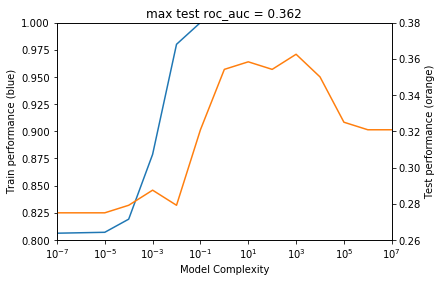

In [15]:
plot_bias_v_variance(c_list,perf_train,perf_test,scoring_option,reg_fit,noreg_fit)

In [16]:
%%capture
# HUP152
X,sc = getNeuData(subj='HUP152')
y = getBehData(sc,apply_circ_shift=apply_circ_shift)

In [17]:
%%capture
# calc bias v variance
c_list,perf_train,perf_test,scoring_option = calc_bias_v_variance(X=X,y=y,\
                                                                  scoring_option = scoring_option,\
                                                                  n_folds = n_folds,penalty=penalty)

reg_fit = doBestFit(X,y,n_folds = n_folds,scoring_option = scoring_option)
noreg_fit = doFit(X,y,n_folds = n_folds,scoring_option = scoring_option)

Classifer performance w hyperparameter tuning=  0.322
Best fit performance without regularization =  0.339


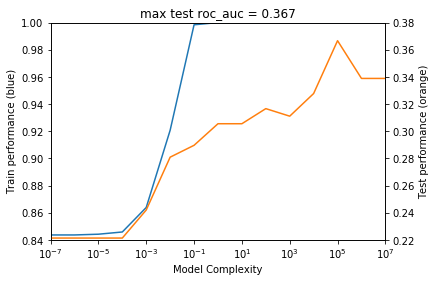

In [18]:
plot_bias_v_variance(c_list,perf_train,perf_test,scoring_option,reg_fit,noreg_fit)

In [19]:
%%capture
# HUP145
X,sc = getNeuData(subj='HUP145')
y = getBehData(sc,apply_circ_shift=apply_circ_shift)

In [20]:
%%capture
# calc bias v variance
c_list,perf_train,perf_test,scoring_option = calc_bias_v_variance(X=X,y=y,\
                                                                  scoring_option = scoring_option,\
                                                                  n_folds = n_folds,penalty=penalty)

reg_fit = doBestFit(X,y,n_folds = n_folds,scoring_option = scoring_option)
noreg_fit = doFit(X,y,n_folds = n_folds,scoring_option = scoring_option)

Classifer performance w hyperparameter tuning=  0.339
Best fit performance without regularization =  0.338


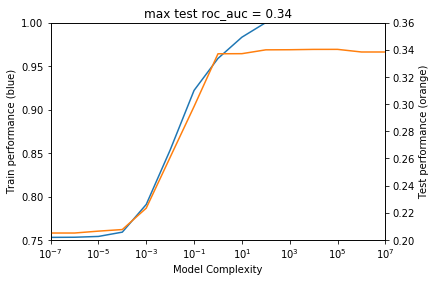

In [21]:
plot_bias_v_variance(c_list,perf_train,perf_test,scoring_option,reg_fit,noreg_fit)